# Warhammer 40,000

Warhammer 40k is a tabletop wargame built around models and dice-rolling, it just so happens my friends and I have recently become rather obsessed with the game, and while learning the rules a number of interesting interactions have cropped up that might be fun to investigate.

### Our combatants
In order to investigate these interactions, we can simulate a skirmish between two simple squads of infantry. I wanted to avoid space marines initially, since theyre the poster boys of this game and always get the attention, but after reviewing the statistics they actually poses a number of properties that will make them ideal for this investigation. Notably they require 2 wounds to eliminate a model, compared to the 1 wound of most other infantry. This could result in unexpected interactions with certain weapons.

Let's go with a squad of 7 Chaos Plague Marines versus a squad of 10 Imperial Guard Stormtroopers, each of these units cost 110 points, so in theory they should be evenly matched.

Before we start throwing too many variables in the mix, let's figure out how to simulate combat, luckily combat in warhammer is just math. Each model has a number of attacks, and each attack has a chance to hit, a chance to wound, and a chance to be saved. So let's start with the simplest case, a single model attacking another single model.

Combat in warhammer is just rolling d6 dice, the higher number rolled, the better the result. More powerfull units will usually require a lower result to achieve a success. For example a typical guardsman needs a 4+ to hit, while a space marine needs a 3+. In this case we'll assume our plague marine is attacking a Stormtrooper, so we'll need a 3+ to hit.

In [1]:
PM_attacks = 2 # The boltgun used by the Plaguemarines fires two shots
PM_hit = 3 # The Plaguemarines have a ballistic skill of 3+
PM_damage = 1  # The boltgun has a damage characteristic of 1
PM_wound = 3 # The boltgun has a strength of 4, while the Stormtroopers have a toughness of 3
PM_AP = 0 # The boltgun has no AP
PM_HP = 2 # The Plaguemarines have 2 wounds each
PM_save = 3 # The Plaguemarines have a save of 3+

ST_attacks = 1 # The HS-Lasgun used by the Stormtroopers fires one shot
ST_hit = 4 # The Stormtroopers have a ballistic skill of 4+
ST_damage = 1 # The HS-Lasgun has a damage characteristic of 1
ST_wound = 5 # The HS-Lasgun has a strength of 3, while the Plaguemarines have a toughness of 4
ST_AP = -1 # The HS-Lasgun has an AP of -1
ST_HP = 1 # The Stormtroopers have one wound each
ST_save = 4# The Stormtroopers have a save of 4+


Let's make a simple function to roll a d6 and return the result.

In [2]:
import random
import numpy as np
def roll(n):
    # Rolling n d6 dice, and storing them in a list
    return np.asarray([random.randint(1,6) for i in range(n)])

print(roll(10))

[6 3 4 5 2 4 1 4 2 1]


Let's see what happens when that one plague marine attacks a single Stormtrooper.

In [3]:
# roll 2 d6, for two attacks
rolls = roll(PM_attacks)
rolls

array([1, 4])

We can now use numpy to filter out only the successes.

In [4]:
hits = sum(rolls >= PM_hit)
hits

1

Now let's see if any of those wound.

In [5]:
# get number of hits
wounds = sum(roll(hits) >= PM_wound)
wounds

0

Now the Stormtrooper gets to make a save, which is a 4+.

interesting to note here, the Stormtrooper takes damage if he fails his save, so unlike the previous rolls we are looking for rolls that are less than the save

In [6]:
damage = sum(roll(wounds) < ST_save+PM_AP) # The Stormtroopers have a save of 4+, while the boltgun has an AP of 0 so the save is 4+
damage

0

Now we subtract the damage from the Stormtroopers health.

In [7]:
HP_remaining = ST_HP - damage
HP_remaining

1

In this particular instance, the Plaguemarine failed to hit the Stormtrooper, so the Stormtrooper took no damage.

Now let's scale this up to whole squads.

An interesting hurdle here is how the Plaguemarines get 2 wounds each, so we cant simply treat their squad as a big blob of HP, as damage doesnt bleed over from model to model. If a model with 2HP takes 6 damage, the remaining 4 damage is wasted. The same goes for the Stormtroopers, if a model with 1HP takes 6 damage, the remaining 5 damage is wasted.

In [8]:
ST_squad = np.asarray([1,1,1,1,1,1,1,1,1,1]) # 10 stormtroopers each have 1 HP
PM_squad = np.asarray([2,2,2,2,2,2,2]) # 7 Plaguemarines each have 2 HP

Let's give the Stormtroopers a chance to shoot back, this time the whole squad.

In [9]:
ST_squad_hits = sum(roll(len(ST_squad)*ST_attacks) >= ST_hit)
ST_squad_hits

4

In [10]:
ST_squad_wounds = sum(roll(ST_squad_hits) >= ST_wound)
ST_squad_wounds

0

In [11]:
ST_squad_successes = sum(roll(ST_squad_wounds) < PM_save+ST_AP)
ST_squad_successes

0

Now it's important here we dont simply subtract this damage from the HP pool of the squad, instead it will be aplied to each model

In [12]:
for success in range(ST_squad_successes):
    PM_squad[0] -= 1 * ST_damage
    if PM_squad[0] <= 0:
        PM_squad = np.delete(PM_squad, 0)
        if len(PM_squad) == 0:
            break

PM_squad

array([2, 2, 2, 2, 2, 2, 2])

We can continue this back and forth, and whichever squad is the last one standing wins.

In [13]:

def ST_shoot(ST_squad, PM_squad):
    # Stormtroopers shoot at Plaguemarines
    ST_squad_hits = sum(roll(len(ST_squad)*ST_attacks) >= ST_hit)
    ST_squad_wounds = sum(roll(ST_squad_hits) >= ST_wound)
    ST_squad_successes = sum(roll(ST_squad_wounds) < PM_save+ST_AP)
    for success in range(ST_squad_successes):
        PM_squad[0] -= 1 * ST_damage
        if PM_squad[0] <= 0:
            PM_squad = np.delete(PM_squad, 0)
            if len(PM_squad) == 0:
                break
    return ST_squad, PM_squad

def PM_shoot(PM_squad, ST_squad):
    # Plaguemarines shoot at Stormtroopers
    PM_squad_hits = sum(roll(len(PM_squad)*PM_attacks) >= PM_hit)
    PM_squad_wounds = sum(roll(PM_squad_hits) >= PM_wound)
    PM_squad_successes = sum(roll(PM_squad_wounds) < ST_save+PM_AP)
    for success in range(PM_squad_successes):
        ST_squad[0] -= 1 * PM_damage
        if ST_squad[0] <= 0:
            ST_squad = np.delete(ST_squad, 0)
            if len(ST_squad) == 0:
                break
    return PM_squad, ST_squad

def fight(ST_squad, PM_squad, first = np.random.choice([0,1])):
    # Fight until one squad is dead or round 10
    round = 1
    rounds = np.zeros((10,2))
    if first == 0:
        while  round <= 9:
            if len(ST_squad) > 0 and len(PM_squad) > 0:
                ST_squad, PM_squad = ST_shoot(ST_squad, PM_squad)
            if len(ST_squad) > 0 and len(PM_squad) > 0:
                PM_squad, ST_squad = PM_shoot(PM_squad, ST_squad)
            rounds[round] = [len(ST_squad), len(PM_squad)]
            round += 1
        if len(ST_squad) == 0:
            return "Plaguemarines win!", PM_squad, rounds
        elif len(PM_squad) == 0:
            return "Stormtroopers win!", ST_squad, rounds
        else:
            return "Draw!", ST_squad, PM_squad, rounds
        
    elif first == 1:
        while  round <= 9:
            if len(ST_squad) > 0 and len(PM_squad) > 0:
                PM_squad, ST_squad = PM_shoot(PM_squad, ST_squad)
            if len(ST_squad) > 0 and len(PM_squad) > 0:
                ST_squad, PM_squad = ST_shoot(ST_squad, PM_squad)
            rounds[round] = [len(ST_squad), len(PM_squad)]
            round += 1
        if len(ST_squad) == 0:
            return "Plaguemarines win!", PM_squad, rounds
        elif len(PM_squad) == 0:
            return "Stormtroopers win!", ST_squad, rounds
        else:
            return "Draw!", ST_squad, PM_squad, rounds
        

In [14]:
PM_squad = np.asarray([2,2,2,2,2,2,2])
ST_squad = np.asarray([1,1,1,1,1,1,1,1,1,1])
print(fight(ST_squad, PM_squad)[0])

Plaguemarines win!


Let's try running this simulation a couple hundred times and see who wins.

In [15]:
ST_wins = 0
PM_wins = 0

for i in range(10000):
    PM_squad = np.asarray([2,2,2,2,2,2,2])
    ST_squad = np.asarray([1,1,1,1,1,1,1,1,1,1])
    if fight(ST_squad, PM_squad)[0] == "Stormtroopers win!":
        ST_wins += 1
    else:
        PM_wins += 1

print("Stormtroopers win {}% of the time".format(ST_wins/(ST_wins+PM_wins)*100))
print("Plaguemarines win {}% of the time".format(PM_wins/(ST_wins+PM_wins)*100))

Stormtroopers win 0.0% of the time
Plaguemarines win 100.0% of the time


Well thats unfortunate, the stormtroopers get rapid fire 1, meaning they get double the shots when they are within half range, so lets see if thats what they need to get the upper hand.

In [16]:
ST_attacks = 2 # The HS-Lasgun used by the Stormtroopers fires two shots in close range

In [17]:
ST_wins = 0
PM_wins = 0

for i in range(10000):
    PM_squad = np.asarray([2,2,2,2,2,2,2])
    ST_squad = np.asarray([1,1,1,1,1,1,1,1,1,1])
    if fight(ST_squad, PM_squad)[0] == "Stormtroopers win!":
        ST_wins += 1
    else:
        PM_wins += 1

print("Stormtroopers win {}% of the time".format(ST_wins/(ST_wins+PM_wins)*100))
print("Plaguemarines win {}% of the time".format(PM_wins/(ST_wins+PM_wins)*100))

Stormtroopers win 0.0% of the time
Plaguemarines win 100.0% of the time


Hmm, still not looking good for the stormtroopers, Imperial Guard have access to orders, a unique buff that can be applied to a squad, so let's give them the Take Aim order, which gives them +1 to hit.

In [18]:
ST_hit = 3 # The Stormtroopers have a ballistic skill of 3+ with the take aim order

In [19]:
ST_wins = 0
PM_wins = 0

for i in range(10000):
    PM_squad = np.asarray([2,2,2,2,2,2,2])
    ST_squad = np.asarray([1,1,1,1,1,1,1,1,1,1])
    results = fight(ST_squad, PM_squad)
    if results[0] == "Stormtroopers win!":
        ST_wins += 1
    else:
        PM_wins += 1
    


print("Stormtroopers win {}% of the time".format(ST_wins/(ST_wins+PM_wins)*100))
print("Plaguemarines win {}% of the time".format(PM_wins/(ST_wins+PM_wins)*100))

Stormtroopers win 0.0% of the time
Plaguemarines win 100.0% of the time


There's hope!
Let's try increasing the number of attacks they get, and see at what point they start winning.

In [20]:
ST_winrate = []
for i in range(25):
    ST_wins = 0
    PM_wins = 0
    ST_attacks = i+1

    for j in range(1000):
        PM_squad = np.asarray([2,2,2,2,2,2,2])
        ST_squad = np.asarray([1,1,1,1,1,1,1,1,1,1])
        results = fight(ST_squad, PM_squad)
        if results[0] == "Stormtroopers win!":
            ST_wins += 1
        else:
            PM_wins += 1

    ST_winrate.append(ST_wins/(ST_wins+PM_wins)*100)

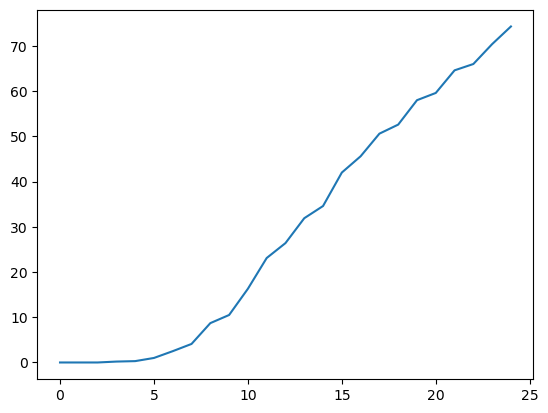

In [21]:
import matplotlib.pyplot as plt
plt.plot(ST_winrate)

So it look like it takes at least 5 attacks per Stormtrooper before they become reasonably effective, and closer to 10 attacks before its a fair fight. 


So lets give the guardsmen 6 attacks each, just for balance sake.

In [22]:
ST_wins = 0
PM_wins = 0
ST_attacks = 10

for j in range(1000):
    PM_squad = np.asarray([2,2,2,2,2,2,2])
    ST_squad = np.asarray([1,1,1,1,1,1,1,1,1,1])
    results = fight(ST_squad, PM_squad)
    if results[0] == "Stormtroopers win!":
        ST_wins += 1
    else:
        PM_wins += 1

print("Stormtroopers win {}% of the time".format(ST_wins/(ST_wins+PM_wins)*100))
print("Plaguemarines win {}% of the time".format(PM_wins/(ST_wins+PM_wins)*100))


Stormtroopers win 11.700000000000001% of the time
Plaguemarines win 88.3% of the time


Now that we've got things even, Lets try giving the plaguemarines one more damage on their guns, intuitivley that should improve their odds.

In [23]:
PM_damage = 2

ST_wins = 0
PM_wins = 0
ST_attacks = 10

for j in range(1000):
    PM_squad = np.asarray([2,2,2,2,2,2,2])
    ST_squad = np.asarray([1,1,1,1,1,1,1,1,1,1])
    results = fight(ST_squad, PM_squad)
    if results[0] == "Stormtroopers win!":
        ST_wins += 1
    else:
        PM_wins += 1

print("Stormtroopers win {}% of the time".format(ST_wins/(ST_wins+PM_wins)*100))
print("Plaguemarines win {}% of the time".format(PM_wins/(ST_wins+PM_wins)*100))


Stormtroopers win 11.600000000000001% of the time
Plaguemarines win 88.4% of the time


Thats the same as before, since the guardsmen only have 1HP the extra damage is wasted. 

Now that we have 2 damage attacks, there's one more thing I'd like to try. On top of the save we've seen so far, there's also a second type called a "feel no pain save", that happens in addition to the regular save for the few units that have access to it. There is one significant difference however, while the standard save can stop incoming attacks, instead the feel-no-pain save stops indivitual wounds. I'm sure this is statistically significant, and it would be fun to see in which situations its better or worse than the conventional save. 

Let's give the Plaguemarines a 5+ feel-no-pain save.

In [24]:
def ST_shoot(ST_squad, PM_squad):
    # Stormtroopers shoot at Plaguemarines
    ST_squad_hits = sum(roll(len(ST_squad)*ST_attacks) >= ST_hit)
    ST_squad_wounds = sum(roll(ST_squad_hits) >= ST_wound)
    ST_squad_successes = sum(roll(ST_squad_wounds) < PM_save+ST_AP)
    for success in range(ST_squad_successes):
        for i in range(ST_damage):
            # Adding in save that occurs with each wound instead of each attack
            if roll(1) < 5:
                PM_squad[0] -= 1 * ST_damage
        if PM_squad[0] <= 0:
            PM_squad = np.delete(PM_squad, 0)
            if len(PM_squad) == 0:
                break
    return ST_squad, PM_squad

In [25]:
PM_damage = 2

ST_wins = 0
PM_wins = 0
ST_attacks = 10

for j in range(1000):
    PM_squad = np.asarray([2,2,2,2,2,2,2])
    ST_squad = np.asarray([1,1,1,1,1,1,1,1,1,1])
    results = fight(ST_squad, PM_squad)
    if results[0] == "Stormtroopers win!":
        ST_wins += 1
    else:
        PM_wins += 1

print("Stormtroopers win {}% of the time".format(ST_wins/(ST_wins+PM_wins)*100))
print("Plaguemarines win {}% of the time".format(PM_wins/(ST_wins+PM_wins)*100))


Stormtroopers win 2.6% of the time
Plaguemarines win 97.39999999999999% of the time


Looks like the save gave a significant advantage to the Plaguemarines, let's try increasing the damage to 2 and see if that changes anything.

In [26]:
ST_damage = 2

In [27]:
ST_wins = 0
PM_wins = 0
ST_attacks = 10

for j in range(1000):
    PM_squad = np.asarray([2,2,2,2,2,2,2])
    ST_squad = np.asarray([1,1,1,1,1,1,1,1,1,1])
    results = fight(ST_squad, PM_squad)
    if results[0] == "Stormtroopers win!":
        ST_wins += 1
    else:
        PM_wins += 1

print("Stormtroopers win {}% of the time".format(ST_wins/(ST_wins+PM_wins)*100))
print("Plaguemarines win {}% of the time".format(PM_wins/(ST_wins+PM_wins)*100))

Stormtroopers win 47.599999999999994% of the time
Plaguemarines win 52.400000000000006% of the time


Woah, all of the sudden the stormtroopers have a huge advantage. Ok, so keeping the attacks at 10, and doubling the damage hugely increased the Stormtroopers chances, what about doing 20 attacks but back at 1 damage?

In [28]:
ST_damage = 1
ST_attacks = 20

ST_wins = 0
PM_wins = 0

for j in range(1000):
    PM_squad = np.asarray([2,2,2,2,2,2,2])
    ST_squad = np.asarray([1,1,1,1,1,1,1,1,1,1])
    results = fight(ST_squad, PM_squad)
    if results[0] == "Stormtroopers win!":
        ST_wins += 1
    else:
        PM_wins += 1

print("Stormtroopers win {}% of the time".format(ST_wins/(ST_wins+PM_wins)*100))
print("Plaguemarines win {}% of the time".format(PM_wins/(ST_wins+PM_wins)*100))

Stormtroopers win 28.499999999999996% of the time
Plaguemarines win 71.5% of the time


Interesting, you can see the feel-no-pain save is much more effective when the damage is spread out over more attacks, but the conventional save is more effective when the damage is concentrated into fewer attacks.